# Load config file

In [15]:
# read config file
from easydict import EasyDict
import json

json_file = "tuglet.json"
with open (json_file, 'r') as config_file:
    try:
        config = json.load(config_file)
        config = EasyDict(config)
    except ValueError:
        print("Invalid json file!")

print(config)

{'exp_name': 'tuglet', 'agent': 'DMKTAgent', 'mode': 'train', 'train_set': 'questions', 'test_set': 'questions', 'metric': 'auc', 'cuda': True, 'gpu_device': 0, 'seed': 3010, 'data_name': 'data_level6', 'min_seq_len': 2, 'max_seq_len': 20, 'q_subseq_len': 8, 'l_subseq_len': 10, 'padding_value': -1, 'max_epoch': 45, 'num_folds': 5, 'num_concepts': 12, 'stride': 50, 'validation_split': 0.2, 'shuffle': True, 'num_workers': 8, 'batch_size': 32, 'test_batch_size': 1024, 'max_subseq_len': 50, 'input_dim': 8, 'init_std': 0.2, 'key_dim': 50, 'value_dim': 50, 'summary_dim': 50, 'optimizer': 'adam', 'learning_rate': 0.01, 'epsilon': 0.1, 'max_grad_norm': 50.0, 'momentum': 0.9, 'weight_decay': 0, 'beta1': 0.5, 'beta2': 0.999, 'save_checkpoint': False, 'log_interval': 10, 'validate_every': 1, 'checkpoint_file': 'checkpoint.pth.tar'}


# Data transformer

In [2]:
import more_itertools as miter

class Padding(object):
    def __init__(self, output_size, side=None, fillvalue=None):
        assert isinstance(side, str)
        self.side = side
        self.output_size = output_size
        self.fillvalue = fillvalue

    def __call__(self, seq):
        if self.side in ['right', None]:
            output = list(miter.padded(seq, fillvalue=self.fillvalue, n=self.output_size))
        elif self.side == 'left':
            output = list(miter.padded(seq[::-1], fillvalue=self.fillvalue, n=self.output_size))
            output = output[::-1]
        else:
            raise AttributeError
        return output

In [3]:
# data transformer
# prepare dataset for data_loader (truncating long sequences and padding the short ones)
from torch.utils.data import Dataset
import numpy as np
from sklearn import metrics

class DKMT_Transformer(Dataset):
    def __init__(self, config, q_records, a_records, sa_records, l_records, 
                pt_q_records=None, pt_a_records=None, pt_sa_records=None, post_test=None):
        self.max_seq_len = config.max_seq_len
        self.q_subseq_len = config.q_subseq_len
        self.l_subseq_len = config.l_subseq_len
        self.padding_value = config.padding_value

        self.post_test = post_test # if validating on post-tests, returns post-test data in addition
        self.num_concepts = config.num_concepts

        self.q_data, self.a_data, self.sa_data, self.l_data = self._transform(
            q_records, a_records, sa_records, l_records
        )
        self.length = len(self.q_data)
        self.pt_q_data = pt_q_records
        self.pt_a_data = pt_a_records
        self.pt_sa_data = pt_sa_records

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        questions = self.q_data[idx] # questions = [Q1, Q2, ...]
        answers = self.a_data[idx]   # answers = [A1, A2, ...]
        student_answers = self.sa_data[idx]
        na_setups = self.l_data[idx] # na_setups = [L1, L2, ...]
    
        # make masks for fake non-assessed activities while training
        na_masks = []
        padding_mask = [0]*self.num_concepts
        padding_mask.append(1)

        true_item_mask = [1]*self.num_concepts
        true_item_mask.append(0)

        for sub_list in na_setups:
            sub_mask = []
            for l in sub_list:
                l = list(l)
                if self.isPaddingSetup(l):
                    sub_mask.append(padding_mask)
                else:
                    sub_mask.append(true_item_mask)
               
            na_masks.append(sub_mask)
        
        # make interaction data (question, response), target answer, target mask, and question_masks
        interactions = []
        target_answers = []
        target_mask = []
        question_masks = []

        for question_list, answer_list, student_answer_list in zip(questions, answers, student_answers):
            interaction_list = []
            sub_mask = []
            for i, q in enumerate(question_list):
                q = list(q)

                # mask
                if self.isPaddingSetup(q):
                    target_mask.append(False)
                    sub_mask.append(padding_mask)
                else:
                    target_mask.append(True)
                    sub_mask.append(true_item_mask)

                # interaction
                q.append(answer_list[i]) 
                interaction_list.append(q)

            interaction_list = np.array(interaction_list, dtype=float)
            interactions.append(interaction_list)

            # target (this is for predicting the correctness of students'answers, 
            # change to student_answer_list if predicting students' answers)
            target_answers.extend(answer_list) 
            assert len(target_answers) == len(target_mask)

            question_masks.append(sub_mask)

        if self.post_test == None:
            return np.array(interactions), na_setups, questions, np.array(target_answers), np.array(target_mask), np.array(question_masks), np.array(na_masks)
        else:
            pt_questions = self.pt_q_data[idx]
            # this is for predicting the correctness of students'answers,
            # change to pt_sa_data[idx] if predicting students'answers
            target_answers.extend(self.pt_a_data[idx]) 
            target_mask.extend([True]*10)
            return np.array(interactions), na_setups, questions, np.array(target_answers), np.array(target_mask), np.array(question_masks), np.array(na_masks), np.array(pt_questions)
            

    def isPaddingSetup(self, setup):
        count = 0
        for x in setup:
            if x == self.padding_value:
                count += 1
        return count == len(setup)
        
    def _transform(self, q_records, a_records, sa_records, l_records):
        q_data = []
        a_data = []
        sa_data = []
        l_data = []

        setup_dim = len(q_records[0][0][0])
        padding_setup = [self.padding_value]*setup_dim

        for q_list, a_list, sa_list, l_list in zip(q_records, a_records, sa_records, l_records):
            assert len(q_list) == len(a_list) == len(sa_list)

            q_padding = Padding(self.max_seq_len, side='left', fillvalue=[padding_setup])
            a_padding = Padding(self.max_seq_len, side='left', fillvalue=[self.padding_value])  
            
            q_list = q_padding(q_list[-self.max_seq_len:])
            a_list = a_padding(a_list[-self.max_seq_len:])
            sa_list = a_padding(sa_list[-self.max_seq_len:])
            l_list = q_padding(l_list[-self.max_seq_len:])

            assert len(q_list) == len(a_list) == len(sa_list) == len(l_list) == self.max_seq_len

            sub_q_padding = Padding(self.q_subseq_len, side='left', fillvalue=padding_setup)
            sub_a_padding = Padding(self.q_subseq_len, side='left', fillvalue=self.padding_value)
            sub_l_padding = Padding(self.l_subseq_len, side='left', fillvalue=padding_setup)

            q_list = [sub_q_padding(sub_list[-self.q_subseq_len:]) for sub_list in q_list]
            a_list = [sub_a_padding(sub_list[-self.q_subseq_len:]) for sub_list in a_list]
            sa_list = [sub_a_padding(sub_list[-self.q_subseq_len:]) for sub_list in sa_list]
            l_list = [sub_l_padding(sub_list[-self.l_subseq_len:]) for sub_list in l_list]

            assert len(q_list[0]) == len(a_list[0]) == len(sa_list[0]) == self.q_subseq_len
            assert len(l_list[0]) == self.l_subseq_len

            q_data.append(q_list)
            a_data.append(a_list)
            l_data.append(l_list)
            sa_data.append(sa_list)

        return np.array(q_data), np.array(a_data), np.array(sa_data), np.array(l_data)

# DMKT model

In [4]:
# DMKT model
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, 150)
        self.linear2 = nn.Linear(150, 300)
        self.linear3 = nn.Linear(300, out_dim)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

class DMKT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.is_cuda = torch.cuda.is_available()
        self.cuda = self.is_cuda & config.cuda
        if self.cuda:
            torch.cuda.manual_seed(config.seed)
            self.device = torch.device("cuda")
        else:
            torch.cuda.manual_seed(config.seed)
            self.device = torch.device("cpu")

        # init parameters
        # self.num_questions = config.num_items
        # self.num_nongradable_items = config.num_nongradable_items
        self.num_concepts = config.num_concepts
        self.key_dim = config.key_dim
        self.value_dim = config.value_dim
        self.summary_dim = config.summary_dim
        self.input_dim = config.input_dim
        self.init_std = config.init_std

        # init matrices
        self.key_matrix = nn.Parameter(torch.randn(self.num_concepts, self.key_dim))
        self.init_std = config.init_std
        nn.init.normal_(self.key_matrix, mean=0, std=self.init_std)
        # self.key_matrix = nn.Parameter(sentence_embeddings)

        self.value_matrix_init = nn.Parameter(torch.randn(self.num_concepts, self.value_dim))
        nn.init.normal_(self.value_matrix_init, mean=0, std=self.init_std)

        # init layers
        self.q_embed_matrix = nn.Linear(config.input_dim, self.key_dim)
        # self.l_embed_matrix = nn.Linear(config.input_dim, self.value_dim)
        self.qa_embed_matrix = nn.Linear(config.input_dim + 1, self.value_dim) 
        # self.q_embed_matrix = SimpleMLP(config.input_dim, self.key_dim)
        # self.l_embed_matrix = SimpleMLP(config.input_dim, self.value_dim)
        # self.qa_embed_matrix = SimpleMLP(config.input_dim + 1, self.value_dim)

        self.erase_linear = nn.Linear(self.value_dim, self.value_dim)
        self.add_linear = nn.Linear(self.value_dim, self.value_dim)
        self.summary_fc = nn.Linear(self.key_dim + self.value_dim, self.summary_dim)
        self.linear_out = nn.Linear(self.summary_dim, 1)

        # initialize activate functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()

    def forward(self, q_data, qa_data, l_data, q_mask, l_mask, pt_q_data = None):
        """
        data_type: np.array
        q_data: batch_size, seq_len, a_subseq_len, 8
        qa_data: batch_size, seq_len, a_subseq_len, 9
        l_data: batch_size, seq_len, na_subseq_len, 8
        """
        q_data = q_data.float()
        qa_data = qa_data.float()
        l_data = l_data.float()
        l_mask = l_mask.float()
        q_mask = q_mask.float()

        batch_size, seq_len = l_data.size(0), l_data.size(1)
        question_len, lec_len =  q_data.size(2), l_data.size(2)

        self.value_matrix =self.value_matrix_init.clone().repeat(batch_size, 1, 1)

        q_read_content = torch.Tensor(batch_size, self.value_dim).to(self.device)
        l_read_content = torch.Tensor(batch_size, self.value_dim).to(self.device)

        ls = torch.Tensor(batch_size, self.value_dim).to(self.device)

        sliced_q_data = torch.chunk(q_data, seq_len, dim=1)
        sliced_qa_data = torch.chunk(qa_data, seq_len, dim=1)
        sliced_l_data = torch.chunk(l_data, seq_len, dim=1)
        sliced_l_mask = torch.chunk(l_mask, seq_len, dim=1)
        sliced_q_mask = torch.chunk(q_mask, seq_len, dim=1)

        batch_pred = []
        for i in range(seq_len):
            nn.init.zeros_(q_read_content)
            nn.init.zeros_(l_read_content)
            nn.init.zeros_(ls)

            q_embed_data = self.q_embed_matrix(sliced_q_data[i].squeeze(1))
            qa_embed_data = self.qa_embed_matrix(sliced_qa_data[i].squeeze(1))
            l_embed_data = self.q_embed_matrix(sliced_l_data[i].squeeze(1))

            sliced_q_embed_data = torch.chunk(q_embed_data, question_len, dim=1)
            sliced_a_embed_data = torch.chunk(qa_embed_data, question_len, dim=1)
            sliced_l_embed_data = torch.chunk(l_embed_data, lec_len, dim=1)

            sub_sliced_l_mask = torch.chunk(sliced_l_mask[i].squeeze(1), lec_len, dim=1)
            sub_sliced_q_mask = torch.chunk(sliced_q_mask[i].squeeze(1),question_len,dim=1)

            for j in range(lec_len):
                l = sliced_l_embed_data[j].squeeze(1)
                l_correlation_weight = self.compute_correlation_weight(l, sub_sliced_l_mask[j].squeeze(1)) # batch_size x (num_concepts + 1)
                l_correlation_weight = l_correlation_weight[:, :-1] # batch_size x num_concepts
                l_read_content += self.read(l_correlation_weight)
                
                self.value_matrix = self.write(l_correlation_weight, l)
                ls += l

            for j in range(question_len):
                q = sliced_q_embed_data[j].squeeze(1)
                qa = sliced_a_embed_data[j].squeeze(1)
                q_correlation_weight = self.compute_correlation_weight(q, sub_sliced_q_mask[j].squeeze(1))
                q_correlation_weight = q_correlation_weight[:, :-1]
                q_read_content = self.read(q_correlation_weight)
                
                mastery_level = torch.cat([q_read_content, q], dim=1)
                summary_output = self.tanh(self.summary_fc(mastery_level))

                batch_sub_pred = self.sigmoid(self.linear_out(summary_output))
                batch_pred.append(batch_sub_pred)
                self.value_matrix = self.write(q_correlation_weight, qa)

        if pt_q_data != None:
            # predict on post-tests 
            pt_q_data = pt_q_data.float()
            num_pt_setups = pt_q_data.size(1)
            pt_embed_data = self.q_embed_matrix(pt_q_data)
            sliced_pt_embed_data = torch.chunk(pt_embed_data, num_pt_setups, dim=1)
            
            for i in range(num_pt_setups):
                q = sliced_pt_embed_data[i].squeeze(1) 
                q_correlation_weight = self.compute_correlation_weight(q)
                q_read_content = self.read(q_correlation_weight)
                mastery_level = torch.cat([q_read_content, q], dim=1)
                summary_output = self.tanh(self.summary_fc(mastery_level))

                batch_sliced_pred = self.sigmoid(self.linear_out(summary_output))
                batch_pred.append(batch_sliced_pred)

        batch_pred = torch.cat(batch_pred, dim=1)
        return batch_pred

    def compute_correlation_weight(self, query_embedded, mask=None):
        """
        use dot product to find the similarity between question embedding and each concept
        embedding stored as key_matrix
        where key-matrix could be understood as all concept embedding covered by the course.

        query_embeded : (batch_size, concept_embedding_dim)
        key_matrix : (num_concepts, concept_embedding_dim)
        output: is the correlation distribution between question and all concepts
        """ 

        similarity = query_embedded @ self.key_matrix.t() # batch_size x num_concepts
        if mask != None:
            batch_size = query_embedded.size(0)
            similarity = torch.cat((similarity, torch.randn(batch_size, 1)), dim=1)
            similarity.masked_fill_(mask == 0, -1e10)

        correlation_weight = torch.softmax(similarity, dim=1)
        return correlation_weight

    def read(self, correlation_weight):
        """
        read function is to read a student's knowledge level on part of concepts covered by a
        target                                         question.
        we could view value_matrix as the latent representation of a student's knowledge
        in terms of all possible concepts.

        value_matrix: (batch_size, num_concepts, concept_embedding_dim)
        correlation_weight: (batch_size, num_concepts)
        """
        batch_size = self.value_matrix.size(0)
        value_matrix_reshaped = self.value_matrix.reshape(
            batch_size * self.num_concepts, self.value_dim
        )
        correlation_weight_reshaped = correlation_weight.reshape(batch_size * self.num_concepts, 1)
        # a (10,3) * b (10,1) = c (10, 3)is every row vector of a multiplies the row scalar of b
        # the multiplication below is to scale the memory embedding by the correlation weight
        rc = value_matrix_reshaped * correlation_weight_reshaped
        read_content = rc.reshape(batch_size, self.num_concepts, self.value_dim)
        read_content = torch.sum(read_content, dim=1)  # sum over all concepts

        return read_content

    def write(self, correlation_weight, interaction_embedded):
        """
        write function is to update memory based on the interaction
        value_matrix: (batch_size, memory_size, memory_state_dim)
        correlation_weight: (batch_size, memory_size)
        qa_embedded: (batch_size, memory_state_dim)
        """
        batch_size = self.value_matrix.size(0)
        erase_vector = self.erase_linear(interaction_embedded)  # (batch_size, memory_state_dim)
        erase_signal = self.sigmoid(erase_vector)

        add_vector = self.add_linear(interaction_embedded)  # (batch_size, memory_state_dim)
        add_signal = self.tanh(add_vector)

        erase_reshaped = erase_signal.reshape(batch_size, 1, self.value_dim)
        cw_reshaped = correlation_weight.reshape(batch_size, self.num_concepts, 1)
        # the multiplication is to generate weighted erase vector for each memory cell
        # therefore, the size is (batch_size, memory_size, memory_state_dim)
        erase_mul = erase_reshaped * cw_reshaped
        memory_after_erase = self.value_matrix * (1 - erase_mul)

        add_reshaped = add_signal.reshape(batch_size, 1, self.value_dim)
        # the multiplication is to generate weighted add vector for each memory cell
        # therefore, the size is (batch_size, memory_size, memory_state_dim)
        add_memory = add_reshaped * cw_reshaped

        updated_memory = memory_after_erase + add_memory
        return updated_memory

# DMKT agent

In [6]:
import torch.optim as optim
from tqdm import tqdm

class DMKTAgent:
    def __init__(self, config, train_loader, test_loader, device=None):
        self.config = config
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.mode = config.mode
        self.model = DMKT(config)
        self.criterion = nn.BCELoss(reduction='sum')
        if config.optimizer == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(),
                                       lr=self.config.learning_rate,
                                       momentum=self.config.momentum)
        else:
            self.optimizer = optim.Adam(self.model.parameters(),
                                        lr=self.config.learning_rate,
                                        eps=self.config.epsilon)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=0,
            min_lr=1e-5,
            factor=0.5,
            verbose=True
        )
        self.num_epochs = config.max_epoch
        self.current_epoch = 0
        self.train_loss_list = []
        self.test_loss_list = []
        self.device = device
        self.best_auc = 0
        self.best_rmse = 1
        self.best_epoch = None
        self.best_model = None
        
    def train(self):
        for epoch in range(1, self.num_epochs + 1):
            if self.mode == 'train':
                self.train_one_epoch(self.train_loader)
            self.current_epoch += 1
            self.validate(self.test_loader)
            print(f"Best ROC-AUC: {self.best_auc}")

    def train_one_epoch(self, train_loader):
        self.model.train()
        print("\n")
        print(f"Train Epoch: {self.current_epoch}")
        print(f"Learning rate: {self.optimizer.param_groups[0]['lr']}")
        train_loss = 0
        train_elements = 0

        for _, data in enumerate(tqdm(train_loader)):
            interactions, na_setups, questions, target_answers, target_mask, a_masks, na_masks, pt_questions = data
            pt_questions = pt_questions.to(self.device)
                    
            interactions = interactions.to(self.device)
            na_setups = na_setups.to(self.device)
            questions = questions.to(self.device)
            target_answers = target_answers.to(self.device)
            target_mask = target_mask.to(self.device)
            a_masks = a_masks.to(self.device)
            na_masks = na_masks.to(self.device)

            self.optimizer.zero_grad() # clear previous gradient

            if self.config.train_set == 'questions':
                output = self.model(questions, interactions, na_setups, a_masks, na_masks)
                target_answers = target_answers[:, :-10] # remove posttests
                target_mask = target_mask[:, :-10]
            else:
                output = self.model(questions, interactions, na_setups, a_masks, na_masks, pt_questions)
                
            output = torch.masked_select(output, target_mask)
            label = torch.masked_select(target_answers, target_mask)

            loss = self.criterion(output.float(), label.float())
            train_loss += loss.item()
            train_elements += target_mask.int().sum()

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
            self.optimizer.step()

        train_loss = train_loss / train_elements
        self.train_loss_list.append(train_loss)
        self.scheduler.step(train_loss)
        print("Train Loss: {:.6f}".format(train_loss))

    def validate(self, test_loader):
        self.model.eval()
        print(f"Validation Result at Epoch {self.current_epoch}")
        test_loss = 0
        test_elements = 0

        pred_labels = []
        true_labels = []

        with torch.no_grad():
            for data in test_loader: 
                interactions, na_setups, questions, target_answers, target_mask, a_masks, na_masks, pt_questions = data
                pt_questions = pt_questions.to(self.device)
                if self.config.test_set == 'posttests':
                    pt_questions = pt_questions.to(self.device)
                    target_answers = target_answers[:, -10:] # remove questions
                    target_mask = target_mask[:, -10:] # remove questions
                elif self.config.test_set == 'questions':
                    target_answers = target_answers[:, :-10] # remove posttests
                    target_mask = target_mask[:, :-10] # remove posttests
              
                interactions = interactions.to(self.device)
                na_setups = na_setups.to(self.device)
                questions = questions.to(self.device)
                target_answers = target_answers.to(self.device)
                target_mask = target_mask.to(self.device)
                a_masks = a_masks.to(self.device)
                na_masks = na_masks.to(self.device)

                if self.config.test_set == 'posttests':
                    output = self.model(questions, interactions, na_setups, a_masks, na_masks, pt_questions)
                    output = output[:, -10:]
                elif self.config.test_set == 'questions_posttests':
                    output = self.model(questions, interactions, na_setups, a_masks, na_masks, pt_questions)
                elif self.config.test_set == 'questions':
                    output = self.model(questions, interactions, na_setups, a_masks, na_masks)
                    
                output = torch.masked_select(output, target_mask)
                label = torch.masked_select(target_answers, target_mask)

                test_loss += self.criterion(output.float(), label.float())
                test_elements += target_mask.int().sum()
                pred_labels.extend(output.tolist())
                true_labels.extend(label.tolist())

            test_loss = test_loss/test_elements
            print("Test Loss: {:.6f}".format(test_loss))
            self.test_loss_list.append(test_loss)
            self.track_best(true_labels, pred_labels)
    
    def track_best(self, true_labels, pred_labels):
        self.pred_labels = np.array(pred_labels).squeeze()
        self.true_labels = np.array(true_labels).squeeze()
        
        rmse = np.sqrt(metrics.mean_squared_error(self.true_labels, self.pred_labels))
        print("RMSE: {:.05}".format(rmse))

        auc = metrics.roc_auc_score(self.true_labels, self.pred_labels)
        print('ROC-AUC: {:.05}'.format(auc))

        if auc > self.best_auc:
            self.best_auc = auc
            self.best_epoch = self.current_epoch
            self.best_model = self.model

# Load data

In [7]:
# load data
import pickle

data_name = config.data_name
data_path = f"datasets/{data_name}.pkl"
data = pickle.load(open(data_path, 'rb'))

print(data.keys())

dict_keys(['q_data', 'a_data', 'l_data', 'sa_data', 'pt_q_data', 'pt_a_data', 'pt_sa_data', 'q_rules_data', 'l_rules_data', 'train', 'test', 'num_assessed_setups', 'num_users', 'num_non_assessed_setups'])


In [8]:
num_users = data["num_users"]
num_assessed_items = data["num_assessed_setups"]
num_non_assessed_items = data["num_non_assessed_setups"]

q_records = data["q_data"] # assessed activities
a_records = data["a_data"] # correctness of students' answers (right/wrong)
sa_records = data["sa_data"] # students' answers (tie/not tie or left/tie/right depend on the dataset)
l_records = data["l_data"] # non-assessed activities
pt_q_records = data["pt_q_data"] # post-test questions
pt_a_records = data["pt_a_data"] 
pt_sa_records = data["pt_sa_data"]

In [9]:
print(f"Number of users: {num_users}:")
print(f"Number of assessed items: {num_assessed_items}")
print(f"Number of non-assessed items: {num_non_assessed_items}")

Number of users: 1746:
Number of assessed items: 191
Number of non-assessed items: 2475


# Train and evaluate model

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler

In [11]:
test_data_pt = DKMT_Transformer(config, data['test']['q_data'], data['test']['a_data'], data['test']['sa_data'],
    data['test']['l_data'], data['test']['pt_q_data'], data['test']['pt_a_data'], data['test']['pt_sa_data'],post_test=True)
train_data_pt = d = DKMT_Transformer(config, data['train']['q_data'], data['train']['a_data'], data['train']['sa_data'],
    data['train']['l_data'], data['train']['pt_q_data'], data['train']['pt_a_data'], data['train']['pt_sa_data'],post_test=True)

## K-fold cross validation

In [16]:
from sklearn.model_selection import KFold

def train_k_folds(dataset):
    num_folds = config.num_folds

    k_fold = KFold(n_splits = num_folds, shuffle=True, random_state=100)
    results = []
    best_model = None
    best_auc = 0
    for fold, (train_ids, test_ids) in enumerate (k_fold.split(dataset)):
        if fold in [0,1,2,3]:
            continue
        print("\n")
        print(f"Train on fold {fold}:")
        train_subsampler = SubsetRandomSampler(train_ids)
        test_subsampler = SubsetRandomSampler(test_ids)
        
        train_loader = DataLoader(dataset, batch_size = config.batch_size, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size= config.batch_size, sampler=test_subsampler)

        agent = DMKTAgent(config, train_loader, test_loader)
        agent.train()
        print(f"Best ROC-AUC for fold {fold}:", agent.best_auc)
        results.append(agent.best_auc)
        if agent.best_auc > best_auc:
            best_auc = agent.best_auc
            best_model = agent.best_model

    average = sum(results) / len(results)
    print("-------------------------")
    print("{}-fold cross validation average result: {:.6f}".format(num_folds, average))
    print(results)

    torch.save(best_model.state_dict(), 'saved_models/best_model')

    return best_model

In [21]:
if 'train_set' not in config or 'test_set' not in config:
    print("Error: Please spectify train_set and test_set in config file")
elif config.train_set not in ['questions', 'posttests', 'questions_posttests']:
    print("Error: Invalid train set")
elif config.test_set not in ['questions', 'posttests', 'questions_posttests']:
    print('Error: Invalid test set')
else:
    print("Start training....")
    best_model = train_k_folds(train_data_pt)

  0%|          | 0/35 [00:00<?, ?it/s]

Start training....


Train on fold 4:


Train Epoch: 0
Learning rate: 0.01


100%|██████████| 35/35 [00:25<00:00,  1.40it/s]


Train Loss: 0.443575
Validation Result at Epoch 1


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.380825
RMSE: 0.34706
ROC-AUC: 0.82652
Best ROC-AUC: 0.8265207788512747


Train Epoch: 1
Learning rate: 0.01


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Train Loss: 0.386279
Validation Result at Epoch 2


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.364667
RMSE: 0.33876
ROC-AUC: 0.83959
Best ROC-AUC: 0.8395903959579932


Train Epoch: 2
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Train Loss: 0.368978
Validation Result at Epoch 3


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.350682
RMSE: 0.3321
ROC-AUC: 0.85375
Best ROC-AUC: 0.8537450782191401


Train Epoch: 3
Learning rate: 0.01


100%|██████████| 35/35 [00:27<00:00,  1.25it/s]


Train Loss: 0.357473
Validation Result at Epoch 4


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.337505
RMSE: 0.32517
ROC-AUC: 0.86698
Best ROC-AUC: 0.8669811159126342


Train Epoch: 4
Learning rate: 0.01


100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Train Loss: 0.346699
Validation Result at Epoch 5


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.338907
RMSE: 0.32651
ROC-AUC: 0.86842
Best ROC-AUC: 0.8684169602273102


Train Epoch: 5
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Train Loss: 0.343081
Validation Result at Epoch 6


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.332443
RMSE: 0.3222
ROC-AUC: 0.8726
Best ROC-AUC: 0.8725972432902045


Train Epoch: 6
Learning rate: 0.01


100%|██████████| 35/35 [00:27<00:00,  1.27it/s]


Train Loss: 0.340871
Validation Result at Epoch 7


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.337182
RMSE: 0.32523
ROC-AUC: 0.87383
Best ROC-AUC: 0.8738265445009236


Train Epoch: 7
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Train Loss: 0.337178
Validation Result at Epoch 8


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.329939
RMSE: 0.32252
ROC-AUC: 0.87949
Best ROC-AUC: 0.8794893106439035


Train Epoch: 8
Learning rate: 0.01


100%|██████████| 35/35 [00:26<00:00,  1.30it/s]


Train Loss: 0.335744
Validation Result at Epoch 9


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.321789
RMSE: 0.31754
ROC-AUC: 0.88211
Best ROC-AUC: 0.8821127228941279


Train Epoch: 9
Learning rate: 0.01


100%|██████████| 35/35 [00:29<00:00,  1.21it/s]


Train Loss: 0.333055
Validation Result at Epoch 10


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.320065
RMSE: 0.31637
ROC-AUC: 0.88308
Best ROC-AUC: 0.8830778597946459


Train Epoch: 10
Learning rate: 0.01


100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Train Loss: 0.332817
Validation Result at Epoch 11


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.320801
RMSE: 0.31725
ROC-AUC: 0.88249
Best ROC-AUC: 0.8830778597946459


Train Epoch: 11
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Train Loss: 0.330109
Validation Result at Epoch 12


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.317681
RMSE: 0.31448
ROC-AUC: 0.8849
Best ROC-AUC: 0.8849016771358615


Train Epoch: 12
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Train Loss: 0.329130
Validation Result at Epoch 13


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.320258
RMSE: 0.31597
ROC-AUC: 0.88526
Best ROC-AUC: 0.8852620476277708


Train Epoch: 13
Learning rate: 0.01


100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Epoch    14: reducing learning rate of group 0 to 5.0000e-03.
Train Loss: 0.329140
Validation Result at Epoch 14


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.320731
RMSE: 0.31626
ROC-AUC: 0.8825
Best ROC-AUC: 0.8852620476277708


Train Epoch: 14
Learning rate: 0.005


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Train Loss: 0.324993
Validation Result at Epoch 15


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.313714
RMSE: 0.31269
ROC-AUC: 0.888
Best ROC-AUC: 0.8880027523461056


Train Epoch: 15
Learning rate: 0.005


100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Train Loss: 0.322654
Validation Result at Epoch 16


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.314997
RMSE: 0.31332
ROC-AUC: 0.88823
Best ROC-AUC: 0.8882340425500759


Train Epoch: 16
Learning rate: 0.005


100%|██████████| 35/35 [00:27<00:00,  1.26it/s]


Train Loss: 0.322419
Validation Result at Epoch 17


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.319969
RMSE: 0.31556
ROC-AUC: 0.88397
Best ROC-AUC: 0.8882340425500759


Train Epoch: 17
Learning rate: 0.005


100%|██████████| 35/35 [00:27<00:00,  1.27it/s]


Epoch    18: reducing learning rate of group 0 to 2.5000e-03.
Train Loss: 0.324104
Validation Result at Epoch 18


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.317663
RMSE: 0.31539
ROC-AUC: 0.88695
Best ROC-AUC: 0.8882340425500759


Train Epoch: 18
Learning rate: 0.0025


100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Train Loss: 0.319467
Validation Result at Epoch 19


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.314951
RMSE: 0.31332
ROC-AUC: 0.8881
Best ROC-AUC: 0.8882340425500759


Train Epoch: 19
Learning rate: 0.0025


100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch    20: reducing learning rate of group 0 to 1.2500e-03.
Train Loss: 0.319836
Validation Result at Epoch 20


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.311560
RMSE: 0.31147
ROC-AUC: 0.88937
Best ROC-AUC: 0.8893676500929919


Train Epoch: 20
Learning rate: 0.00125


100%|██████████| 35/35 [00:30<00:00,  1.14it/s]


Train Loss: 0.317408
Validation Result at Epoch 21


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310426
RMSE: 0.31121
ROC-AUC: 0.89047
Best ROC-AUC: 0.890470799666661


Train Epoch: 21
Learning rate: 0.00125


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


Train Loss: 0.316969
Validation Result at Epoch 22


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.311009
RMSE: 0.31143
ROC-AUC: 0.88981
Best ROC-AUC: 0.890470799666661


Train Epoch: 22
Learning rate: 0.00125


100%|██████████| 35/35 [00:27<00:00,  1.29it/s]


Train Loss: 0.316571
Validation Result at Epoch 23


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.311321
RMSE: 0.31158
ROC-AUC: 0.88982
Best ROC-AUC: 0.890470799666661


Train Epoch: 23
Learning rate: 0.00125


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Train Loss: 0.316416
Validation Result at Epoch 24


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310841
RMSE: 0.31124
ROC-AUC: 0.88979
Best ROC-AUC: 0.890470799666661


Train Epoch: 24
Learning rate: 0.00125


100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Train Loss: 0.315892
Validation Result at Epoch 25


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310722
RMSE: 0.31126
ROC-AUC: 0.8901
Best ROC-AUC: 0.890470799666661


Train Epoch: 25
Learning rate: 0.00125


100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Train Loss: 0.315834
Validation Result at Epoch 26


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310625
RMSE: 0.31116
ROC-AUC: 0.89034
Best ROC-AUC: 0.890470799666661


Train Epoch: 26
Learning rate: 0.00125


100%|██████████| 35/35 [00:26<00:00,  1.31it/s]


Train Loss: 0.315704
Validation Result at Epoch 27


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309715
RMSE: 0.31061
ROC-AUC: 0.89071
Best ROC-AUC: 0.8907105829582098


Train Epoch: 27
Learning rate: 0.00125


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


Train Loss: 0.315000
Validation Result at Epoch 28


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310296
RMSE: 0.31107
ROC-AUC: 0.89005
Best ROC-AUC: 0.8907105829582098


Train Epoch: 28
Learning rate: 0.00125


100%|██████████| 35/35 [00:27<00:00,  1.26it/s]


Epoch    29: reducing learning rate of group 0 to 6.2500e-04.
Train Loss: 0.315063
Validation Result at Epoch 29


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309815
RMSE: 0.31074
ROC-AUC: 0.89059
Best ROC-AUC: 0.8907105829582098


Train Epoch: 29
Learning rate: 0.000625


100%|██████████| 35/35 [00:27<00:00,  1.28it/s]


Train Loss: 0.314323
Validation Result at Epoch 30


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309939
RMSE: 0.31072
ROC-AUC: 0.89059
Best ROC-AUC: 0.8907105829582098


Train Epoch: 30
Learning rate: 0.000625


100%|██████████| 35/35 [00:26<00:00,  1.31it/s]


Train Loss: 0.313832
Validation Result at Epoch 31


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309813
RMSE: 0.3107
ROC-AUC: 0.89064
Best ROC-AUC: 0.8907105829582098


Train Epoch: 31
Learning rate: 0.000625


100%|██████████| 35/35 [00:26<00:00,  1.32it/s]


Train Loss: 0.313707
Validation Result at Epoch 32


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.310215
RMSE: 0.31091
ROC-AUC: 0.89037
Best ROC-AUC: 0.8907105829582098


Train Epoch: 32
Learning rate: 0.000625


100%|██████████| 35/35 [00:24<00:00,  1.40it/s]


Epoch    33: reducing learning rate of group 0 to 3.1250e-04.
Train Loss: 0.314149
Validation Result at Epoch 33


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309597
RMSE: 0.31067
ROC-AUC: 0.89087
Best ROC-AUC: 0.8908668996994179


Train Epoch: 33
Learning rate: 0.0003125


100%|██████████| 35/35 [00:24<00:00,  1.41it/s]


Train Loss: 0.313260
Validation Result at Epoch 34


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309825
RMSE: 0.3107
ROC-AUC: 0.89064
Best ROC-AUC: 0.8908668996994179


Train Epoch: 34
Learning rate: 0.0003125


100%|██████████| 35/35 [00:24<00:00,  1.41it/s]


Train Loss: 0.313074
Validation Result at Epoch 35


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309780
RMSE: 0.31079
ROC-AUC: 0.89076
Best ROC-AUC: 0.8908668996994179


Train Epoch: 35
Learning rate: 0.0003125


100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


Train Loss: 0.313039
Validation Result at Epoch 36


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309724
RMSE: 0.31077
ROC-AUC: 0.89084
Best ROC-AUC: 0.8908668996994179


Train Epoch: 36
Learning rate: 0.0003125


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


Epoch    37: reducing learning rate of group 0 to 1.5625e-04.
Train Loss: 0.313152
Validation Result at Epoch 37


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309807
RMSE: 0.31078
ROC-AUC: 0.8908
Best ROC-AUC: 0.8908668996994179


Train Epoch: 37
Learning rate: 0.00015625


100%|██████████| 35/35 [00:26<00:00,  1.32it/s]


Train Loss: 0.312815
Validation Result at Epoch 38


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309613
RMSE: 0.31066
ROC-AUC: 0.89083
Best ROC-AUC: 0.8908668996994179


Train Epoch: 38
Learning rate: 0.00015625


100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


Train Loss: 0.312693
Validation Result at Epoch 39


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309611
RMSE: 0.31063
ROC-AUC: 0.89081
Best ROC-AUC: 0.8908668996994179


Train Epoch: 39
Learning rate: 0.00015625


100%|██████████| 35/35 [00:26<00:00,  1.32it/s]


Epoch    40: reducing learning rate of group 0 to 7.8125e-05.
Train Loss: 0.312702
Validation Result at Epoch 40


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309533
RMSE: 0.3106
ROC-AUC: 0.89087
Best ROC-AUC: 0.8908720980547461


Train Epoch: 40
Learning rate: 7.8125e-05


100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


Train Loss: 0.312567
Validation Result at Epoch 41


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309558
RMSE: 0.31063
ROC-AUC: 0.89084
Best ROC-AUC: 0.8908720980547461


Train Epoch: 41
Learning rate: 7.8125e-05


100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


Epoch    42: reducing learning rate of group 0 to 3.9063e-05.
Train Loss: 0.312588
Validation Result at Epoch 42


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309665
RMSE: 0.31069
ROC-AUC: 0.89078
Best ROC-AUC: 0.8908720980547461


Train Epoch: 42
Learning rate: 3.90625e-05


100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Train Loss: 0.312480
Validation Result at Epoch 43


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309580
RMSE: 0.31062
ROC-AUC: 0.89081
Best ROC-AUC: 0.8908720980547461


Train Epoch: 43
Learning rate: 3.90625e-05


100%|██████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch    44: reducing learning rate of group 0 to 1.9531e-05.
Train Loss: 0.312477
Validation Result at Epoch 44


  0%|          | 0/35 [00:00<?, ?it/s]

Test Loss: 0.309614
RMSE: 0.31064
ROC-AUC: 0.89078
Best ROC-AUC: 0.8908720980547461


Train Epoch: 44
Learning rate: 1.953125e-05


100%|██████████| 35/35 [00:28<00:00,  1.25it/s]


Train Loss: 0.312440
Validation Result at Epoch 45
Test Loss: 0.309599
RMSE: 0.31063
ROC-AUC: 0.89079
Best ROC-AUC: 0.8908720980547461
Best ROC-AUC for fold 4: 0.8908720980547461
-------------------------
5-fold cross validation average result: 0.890872
[0.8908720980547461]


## Validate on test set

In [22]:
# cchange tet set to 'posttests' if evaluating on posttests
config.test_set = 'posttests'

In [23]:
train_loader = DataLoader(test_data_pt, batch_size = len(test_data_pt)) # not important 
test_loader = DataLoader(test_data_pt, batch_size = len(test_data_pt))

In [24]:
agent = DMKTAgent(config, train_loader, test_loader)
agent.model = best_model
agent.validate(test_loader)

Validation Result at Epoch 0
Test Loss: 0.820000
RMSE: 0.55423
ROC-AUC: 0.61031


# Analyze 

In [25]:
model = DMKT(config)
model.load_state_dict(torch.load('saved_models/best_model'))

<All keys matched successfully>

In [26]:
data = pickle.load(open('datasets/setups.pkl', 'rb'))
print(data.keys())

dict_keys(['all_setups', 'a_setups', 'na_setups', 'a_rules', 'na_rules', 'all_rules'])


## Concept visualization

In [27]:
# get correlation weights of setups
def get_correlation_weight(setups, model):
    setup_embedded = model.q_embed_matrix(setups)
    correlation_weight = model.compute_correlation_weight(setup_embedded)
    return correlation_weight

In [28]:
def get_labels(cw):
    labels = []
    for x in cw:
        id = np.argmax(x)
        labels.append(id)
    return labels

In [29]:
setups = data['all_setups']

In [30]:
cw = get_correlation_weight(torch.tensor(setups).float(), model)
cw = cw.detach().numpy()

In [31]:
cw

array([[6.3469134e-02, 2.5717616e-02, 1.0758514e-02, ..., 3.8155696e-01,
        5.3489911e-03, 2.4095684e-01],
       [1.7234650e-02, 4.6599358e-02, 3.3801771e-04, ..., 3.2034305e-01,
        2.4012115e-03, 5.2530581e-01],
       [7.7319779e-02, 9.8762214e-03, 3.8917342e-03, ..., 1.4048095e-01,
        6.2962305e-03, 3.9752230e-01],
       ...,
       [3.2297542e-06, 8.3123545e-05, 8.7755370e-01, ..., 2.5503048e-05,
        8.0553547e-02, 1.1790314e-05],
       [6.3936509e-06, 4.2506785e-04, 5.9091789e-01, ..., 8.8772780e-05,
        2.0503293e-01, 6.6133471e-05],
       [6.5521026e-06, 1.1252383e-03, 2.0598359e-01, ..., 1.5996292e-04,
        2.7015561e-01, 1.9203022e-04]], dtype=float32)

In [32]:
labels = get_labels(cw)
labels

[9,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 2,
 9,
 9,
 9,
 4,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 2,
 7,
 7,
 4,
 7,
 4,
 11,
 2,
 2,
 4,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 11,
 2,
 11,
 11,
 3,
 11,
 11,
 3,
 2,
 2,
 2,
 7,
 2,
 2,
 7,
 7,
 4,
 4,
 7,
 7,
 4,
 4,
 2,
 2,
 2,
 7,
 2,
 2,
 7,
 7,
 4,
 4,
 4,
 2,
 2,
 2,
 7,
 2,
 4,
 11,
 11,
 11,
 11,
 11,
 2,
 2,
 9,
 11,
 11,
 2,
 2,
 7,
 7,
 2,
 7,
 4,
 7,
 4,
 2,
 2,
 7,
 4,
 7,
 7,
 4,
 2,
 11,
 2,
 2,
 7,
 7,
 7,
 4,
 11,
 2,
 4,
 11,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 7,
 3,
 3,
 11,
 11,
 11,
 5,
 9,
 9,
 4,
 11,
 11,
 11,
 11,
 9,
 11,
 11,
 9,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 2,
 9,
 9,
 4,
 4,
 11,
 11,
 9,
 11,
 9,
 4,
 9,
 11,
 9,
 9,
 7,
 2,
 4,
 4,
 2,
 4,
 4,
 11,
 9,
 11,
 3,
 9,
 11,
 2,
 2,
 2,
 2,
 2,
 2,
 

In [34]:
len(np.unique(labels))

11

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold
from sklearn.decomposition import PCA

In [35]:
# reduce dimension by T-SNE
tsne = manifold.TSNE(n_components=2, random_state=42)
cw_embedded = tsne.fit_transform(cw)

/home/iris/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/iris/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [38]:
# reduce dimension by PCA
pca = PCA(n_components=2)
cw_embedded = pca.fit_transform(cw)

In [39]:
# create dataframe for plotting scatter diagram
df = pd.DataFrame(columns=['x', 'y', 'Labels'], data=np.column_stack((cw_embedded, labels)))
df

,x,y,Labels
0,-0.315906,-0.187451,9.0
1,-0.396981,-0.278658,11.0
2,-0.359416,-0.255883,11.0
3,-0.480612,-0.424981,11.0
4,-0.495524,-0.456410,11.0
...,...,...,...
2571,0.716598,-0.137230,2.0
2572,0.644742,-0.090749,2.0
2573,0.593761,-0.088028,2.0
2574,0.302222,0.084137,2.0


/home/iris/anaconda3/envs/deepkt/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


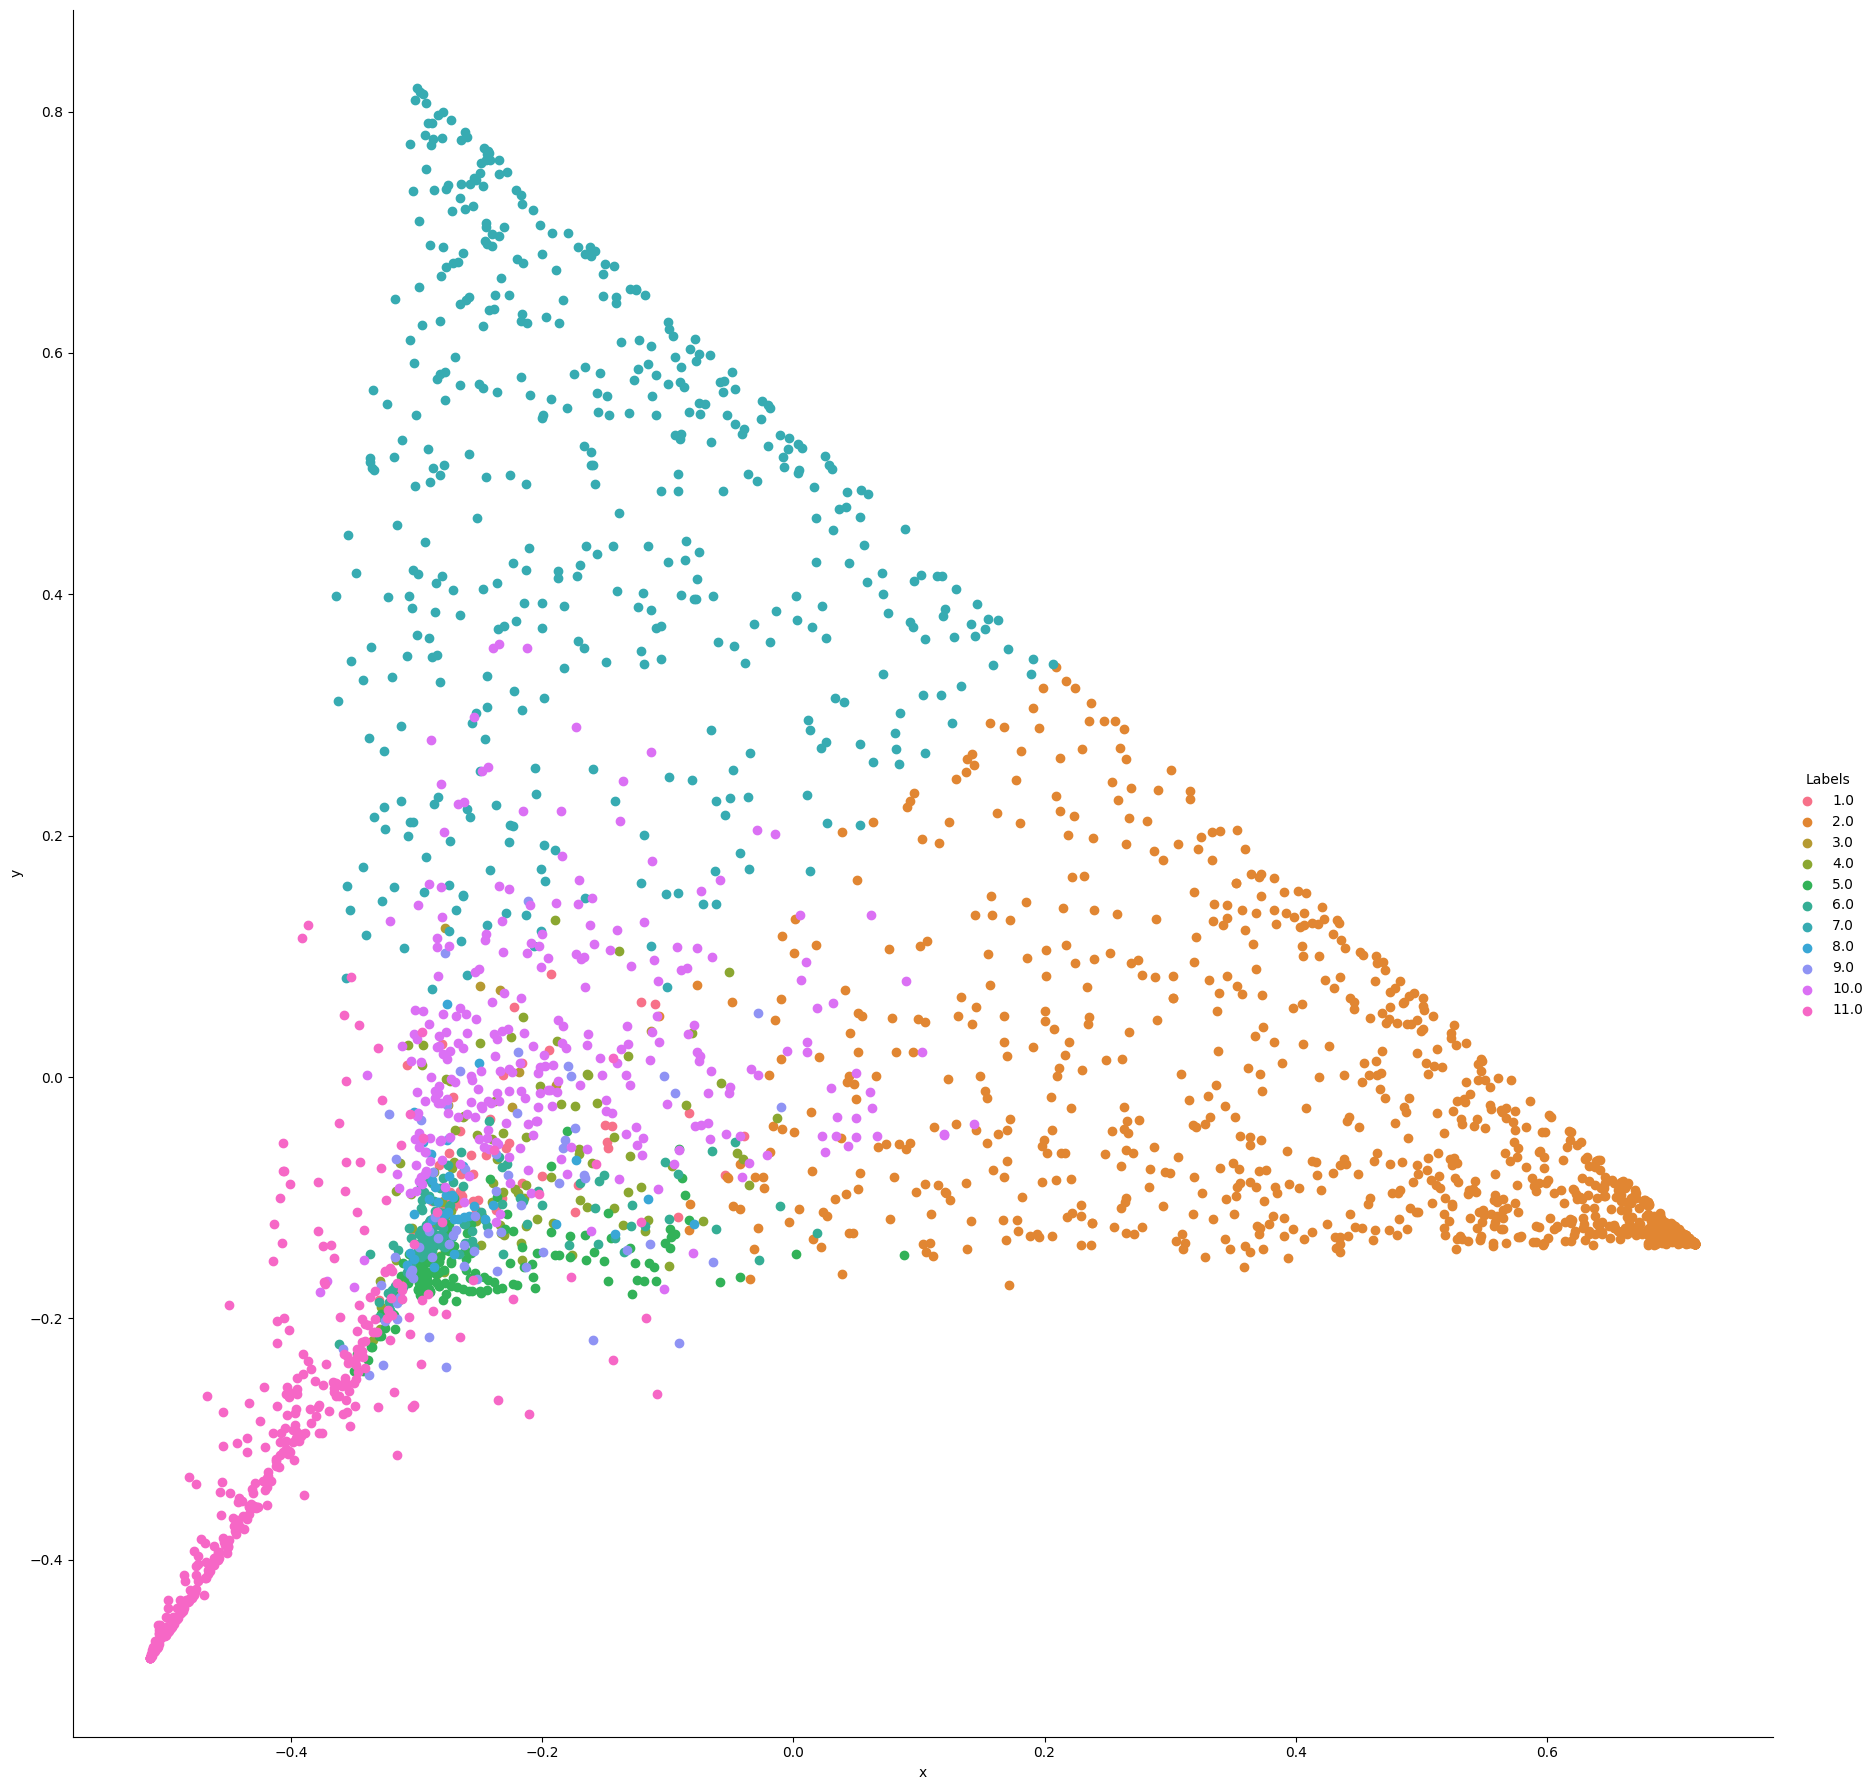

In [40]:
grid = sns.FacetGrid(df, hue="Labels", size=18)
grid.map(plt.scatter, 'x', 'y').add_legend()

## Cluster students based on their knowledge states (value matrices)

In [41]:
all_data = DKMT_Transformer(config, q_records, a_records, sa_records, l_records)
data_loader = DataLoader(all_data,batch_size=len(all_data))

In [42]:
def get_value_matrix(all_data, model):
    with torch.no_grad():
        for data in data_loader:
            interactions, na_setups, questions, target_answers, target_mask, a_masks, na_masks = data
                
            interactions = interactions.to(model.device)
            na_setups = na_setups.to(model.device)
            questions = questions.to(model.device)
            target_answers = target_answers.to(model.device)
            target_mask = target_mask.to(model.device)
            a_masks = a_masks.to(model.device)
            na_masks = na_masks.to(model.device)
            output = model(questions, interactions, na_setups, a_masks, na_masks)
            value_matrices = model.value_matrix
    return value_matrices

In [43]:
value_matrices = get_value_matrix(all_data, model)

In [44]:
value_matrices = value_matrices.reshape(num_users, config.num_concepts*config.value_dim)
value_matrices.size()

torch.Size([1746, 600])

In [45]:
# use students' posttest scores as labels
scores = []
for a_list in pt_a_records:
    scores.append(a_list.count(1))
scores

[8,
 10,
 6,
 6,
 7,
 9,
 10,
 10,
 10,
 9,
 10,
 7,
 6,
 6,
 7,
 9,
 9,
 8,
 9,
 8,
 9,
 9,
 9,
 7,
 6,
 10,
 9,
 6,
 7,
 8,
 8,
 9,
 10,
 9,
 9,
 7,
 9,
 9,
 9,
 8,
 8,
 8,
 6,
 9,
 9,
 9,
 9,
 10,
 6,
 10,
 9,
 9,
 6,
 6,
 9,
 8,
 7,
 10,
 9,
 8,
 6,
 9,
 10,
 10,
 10,
 9,
 9,
 10,
 9,
 9,
 10,
 7,
 7,
 10,
 7,
 8,
 9,
 8,
 9,
 10,
 9,
 8,
 8,
 9,
 6,
 10,
 9,
 9,
 9,
 9,
 8,
 9,
 10,
 8,
 8,
 9,
 6,
 9,
 10,
 9,
 9,
 8,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 8,
 9,
 9,
 7,
 9,
 10,
 7,
 6,
 8,
 10,
 7,
 9,
 8,
 10,
 10,
 7,
 9,
 8,
 7,
 8,
 9,
 9,
 7,
 9,
 7,
 7,
 7,
 8,
 9,
 7,
 10,
 7,
 7,
 9,
 8,
 8,
 8,
 7,
 9,
 6,
 6,
 9,
 8,
 6,
 9,
 8,
 7,
 8,
 8,
 9,
 10,
 10,
 6,
 7,
 10,
 9,
 7,
 9,
 7,
 10,
 7,
 7,
 7,
 8,
 9,
 8,
 8,
 7,
 9,
 9,
 7,
 7,
 7,
 7,
 8,
 7,
 10,
 7,
 9,
 7,
 9,
 7,
 9,
 9,
 9,
 6,
 8,
 9,
 10,
 8,
 8,
 7,
 9,
 9,
 9,
 7,
 10,
 6,
 9,
 9,
 7,
 9,
 8,
 10,
 10,
 9,
 8,
 7,
 7,
 7,
 8,
 8,
 10,
 10,
 8,
 9,
 9,
 8,
 7,
 10,
 9,
 10,
 10,
 6,
 7,
 9,
 10,
 9,
 9,
 8,
 10,

(array([188., 447., 329., 474., 308.]),
 array([ 5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <BarContainer object of 5 artists>)

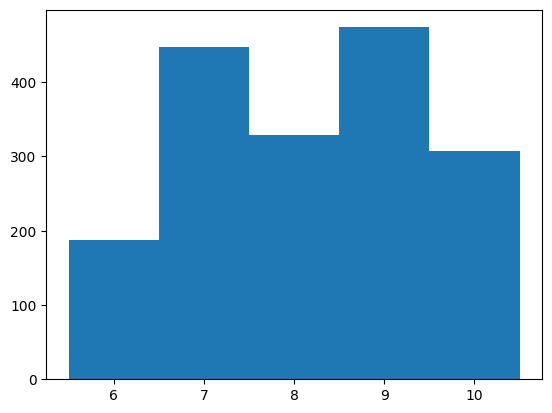

In [46]:
# distribution of posttest scores
plt.hist(scores, bins = np.arange(min(scores), max(scores) + 1.5) - 0.5)

In [47]:
labels = []
for s in scores:
    if s < 7:
        labels.append('Bad')
    elif s > 9:
        labels.append('Good')
    else:
        labels.append('Average')
labels

['Average',
 'Good',
 'Bad',
 'Bad',
 'Average',
 'Average',
 'Good',
 'Good',
 'Good',
 'Average',
 'Good',
 'Average',
 'Bad',
 'Bad',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Bad',
 'Good',
 'Average',
 'Bad',
 'Average',
 'Average',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Bad',
 'Average',
 'Average',
 'Average',
 'Average',
 'Good',
 'Bad',
 'Good',
 'Average',
 'Average',
 'Bad',
 'Bad',
 'Average',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Bad',
 'Average',
 'Good',
 'Good',
 'Good',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Good',
 'Average',
 'Average',
 'Average',
 'Average',
 'Bad',
 'Good',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average',
 'Average'

In [48]:
x = value_matrices.detach().numpy()

In [49]:
# reduce dimension by T-SNE
tsne = manifold.TSNE(n_components=2, random_state=42)
x_embedded = tsne.fit_transform(x)

/home/iris/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/iris/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
# reduce dimension by PCA
pca = PCA(n_components=2)
x_embedded = pca.fit_transform(x)

In [ ]:
df = pd.DataFrame(columns=['x', 'y', 'Labels'], data=np.column_stack((x_embedded, labels)))
df

In [ ]:
grid = sns.FacetGrid(df, hue="Labels", size=12)
grid.map(plt.scatter, 'x', 'y').add_legend()

## Knowledge state changing visualization

In [55]:
def knowledge_states(model, q_data, l_data, qa_data, q_mask, l_mask):
    value_matrices = []
    q_data = q_data.float()
    qa_data = qa_data.float()
    l_data = l_data.float()
    l_mask = l_mask.float()
    q_mask = q_mask.float()

    batch_size, seq_len = l_data.size(0), l_data.size(1)
    question_len, lec_len =  q_data.size(2), l_data.size(2)
    model.value_matrix = model.value_matrix_init.clone().repeat(batch_size, 1, 1)

    q_read_content = torch.Tensor(batch_size, model.value_dim).to(model.device)
    l_read_content = torch.Tensor(batch_size, model.value_dim).to(model.device)


    ls = torch.Tensor(batch_size, model.value_dim).to(model.device)

    sliced_q_data = torch.chunk(q_data, seq_len, dim=1)
    sliced_qa_data = torch.chunk(qa_data, seq_len, dim=1)
    sliced_l_data = torch.chunk(l_data, seq_len, dim=1)
    sliced_l_mask = torch.chunk(l_mask, seq_len, dim=1)
    sliced_q_mask = torch.chunk(q_mask, seq_len, dim=1)

    # get initial concept states
    generated_cws = torch.eye(model.num_concepts).to(model.device)
    concept_states = []
    for cw in generated_cws:
        cw =cw.clone().repeat(batch_size, 1,1)
        read_content = model.read(cw)
        q = torch.zeros(batch_size, model.key_dim)              
        mastery_level =torch.cat([read_content, q], dim=1)
        summary_output = model.tanh(model.summary_fc(mastery_level))
        output = model.sigmoid(model.linear_out(summary_output))
        concept_states.append(output)
    concept_states = torch.cat(concept_states, dim=1)
    value_matrices.append(concept_states)

    for i in range(seq_len):
        nn.init.zeros_(q_read_content)
        nn.init.zeros_(l_read_content)
        nn.init.zeros_(ls)

        q_embed_data = model.q_embed_matrix(sliced_q_data[i].squeeze(1))
        qa_embed_data = model.qa_embed_matrix(sliced_qa_data[i].squeeze(1))
        l_embed_data = model.q_embed_matrix(sliced_l_data[i].squeeze(1))

        sliced_q_embed_data = torch.chunk(q_embed_data, question_len, dim=1)
        sliced_a_embed_data = torch.chunk(qa_embed_data, question_len, dim=1)
        sliced_l_embed_data = torch.chunk(l_embed_data, lec_len, dim=1)

        sub_sliced_l_mask = torch.chunk(sliced_l_mask[i].squeeze(1), lec_len, dim=1)
        sub_sliced_q_mask = torch.chunk(sliced_q_mask[i].squeeze(1),question_len,dim=1)

        for j in range(lec_len):
            l = sliced_l_embed_data[j].squeeze(1)
            l_correlation_weight = model.compute_correlation_weight(l, sub_sliced_l_mask[j].squeeze(1)) # batch_size x (num_concepts + 1)
            l_correlation_weight = l_correlation_weight[:, :-1] # batch_size x num_concepts
            model.value_matrix = model.write(l_correlation_weight, l)

        for j in range(question_len):
            q = sliced_q_embed_data[j].squeeze(1)
            qa = sliced_a_embed_data[j].squeeze(1)
            q_correlation_weight = model.compute_correlation_weight(q, sub_sliced_q_mask[j].squeeze(1))
            q_correlation_weight = q_correlation_weight[:, :-1]
            model.value_matrix = model.write(q_correlation_weight, qa)
            
            concept_states = []
            for cw in generated_cws:
                cw =cw.clone().repeat(batch_size, 1,1)
                read_content = model.read(cw)
                q = torch.zeros(batch_size, model.key_dim)              
                mastery_level =torch.cat([read_content, q], dim=1)
                summary_output = model.tanh(model.summary_fc(mastery_level))
                output = model.sigmoid(model.linear_out(summary_output))
                concept_states.append(output)
           
            concept_states = torch.cat(concept_states, dim=1)
            value_matrices.append(concept_states)

    value_matrices = torch.cat(value_matrices, dim=1)
    value_matrices = value_matrices.view(1746, 161, 12)
    return value_matrices

In [56]:
with torch.no_grad():
    for data in data_loader:
        interactions, na_setups, questions, target_answers, target_mask, a_masks, na_masks = data
        value_matrices = knowledge_states(best_model, questions, na_setups, interactions, a_masks, na_masks)
        value_matrices.numpy()

In [61]:
def knowledge_states_visualize(user_id, value_matrices):
    knowledge_states = value_matrices[user_id].detach().numpy()
    true_knowledge_states = []
    answers = []
    true_knowledge_states.append(knowledge_states[0])
    for i, mask in enumerate(target_mask[user_id]):
        if mask:
            true_knowledge_states.append(knowledge_states[i+1])
            answers.append(target_answers[user_id][i].numpy())

    true_knowledge_states = np.array(true_knowledge_states).T
    sns.set(rc = {'figure.figsize':(30,8)})
    xlabels = [i for i in range(true_knowledge_states.shape[1])]
    ylabels = [i + 1 for i in range(true_knowledge_states.shape[0])]
    ax = sns.heatmap(true_knowledge_states, cmap="YlGnBu", square=True, xticklabels=xlabels, yticklabels=ylabels)

    print(answers)

[array(1), array(1), array(1), array(1), array(0), array(1), array(1), array(1), array(1), array(0), array(1), array(1), array(1), array(1), array(1), array(1)]


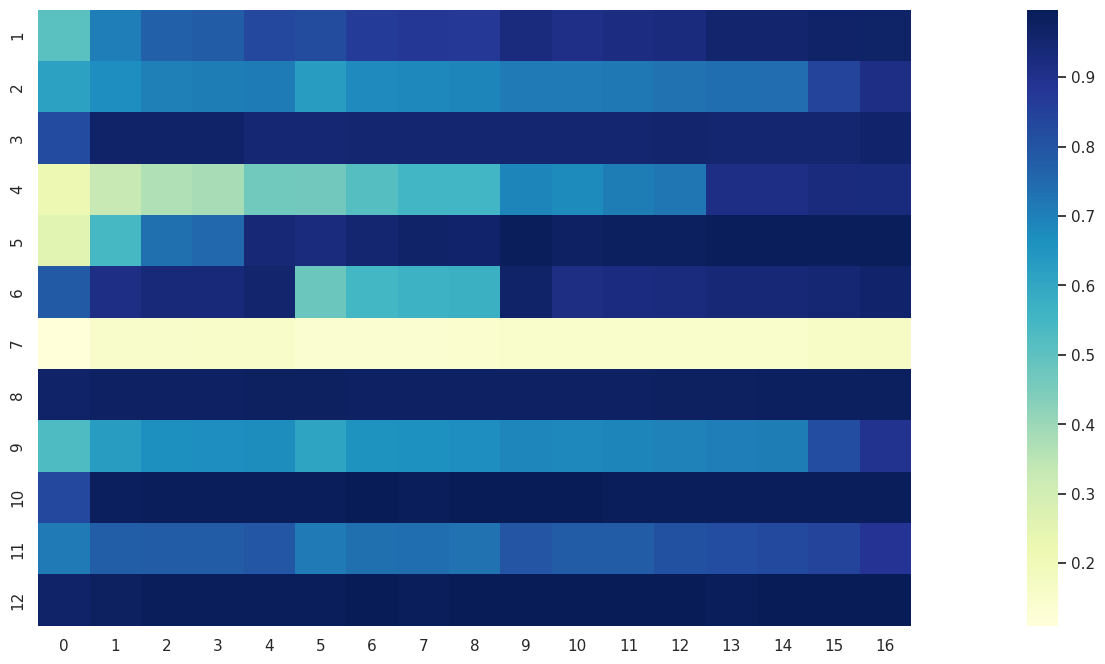

In [62]:
knowledge_states_visualize(0, value_matrices)